# ECE/CS 434 | MP2: DUET
<br />
<nav>
    <span class="alert alert-block alert-warning">Due on Wednesday Feb 21 11:59PM on Gradescope</span>
   
</nav><br> 


## Objective
In this MP, you will:
- Implement DUET algorithm to separate a mixture of N voice signals from received from two microphones

---
## Problem Overview
Consider a problem of separating N sources ($S_1$, $S_2$, ... $S_N$) from recordings on 2 microphones ($R_1$ and $R_2$).
According to DUET algorithm, you will need to perform the following steps:

- Calculate the short-time Fourier transform of two received signals to get the time-frequency spectrograms
- Calculate the ratio of the two time-frequency spectrograms to get relative delay and attenuation
- Cluster the time-frequency bins in the 2D space spanned by relative delay and attenuation
- Recover the original N signals based on the clustering results

You can refer to the original DUET paper in ICASSP 2000: "Blind separation of disjoint orthogonal signals: demixing N sources from 2 mixtures" and this tutorial in Blind speech separation, 2007 - Springer: "The DUET blind source separation algorithm"

For the sake of easier clustering, the exact number of sources N will be provided to you.

You can assume there is no time-frequency bin collision for any two sources.

---
## Imports & Setup
To run the grading script of this MP, you will need to install the Python [SpeechRecognition](https://pypi.org/project/SpeechRecognition/) package. The SpeechRecognition package also requires the dependency [pocketsphinx](https://pypi.org/project/pocketsphinx/). You may directly use pip install to install both packages.
The following `code` cell, when run, imports the libraries you might need for this MP. Feel free to delete or import other commonly used libraries. Double check with the TA if you are unsure if a library is supported.

In [1]:
import numpy as np
import scipy.io.wavfile
import speech_recognition as sr

# Custom Imports
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from sklearn.cluster import KMeans
from scipy import cluster

# for np.ceil
import math

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    # plt.style.use("seaborn") # This sets the matplotlib color scheme to something more soothing
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

### Sanity-check

Running the following code block verifies that the correct module versions are indeed being used. 

Try restarting the Python kernel (or Jupyter) if there is a mismatch even after intalling the correct version. This might happen because Python's `import` statement does not reload already-loaded modules even if they are updated.

In [2]:
if __name__ == '__main__':
    from IPython.display import display, HTML

    def printc(text, color):
        display(HTML("<text style='color:{};weight:700;'>{}</text>".format(color, text)))

    _requirements = [r.split("==") for r in open(
        "packages.txt", "r").read().split("\n")]

    import sys
    for (module, expected_version) in _requirements:
        try:
            if sys.modules[module].__version__ != expected_version:
                printc("[✕] {} version should to be {}, but {} is installed.".format(
                    module, expected_version, sys.modules[module].__version__), "#f44336")
            else:
                printc("[✓] {} version {} is correct.".format(
                    module, expected_version), "#4caf50")
        except:
            printc("[–] {} is not imported, skipping version check.".format(
                module), "#03a9f4")

---
## Your Implementation
Implement your localization algorithm in the function `duet_source_separation(mic_data_folder, NUM_SOURCES)`. Do **NOT** change its function signature. You are, however, free to define and use helper functions. 

Your implementation for `duet_source_separation` function should **NOT** output any plots or data. It should only return the user's calculated location.

In [89]:
def duet_source_separation(mic_data_folder, NUM_SOURCES):
    """DUET source separation algorithm. Write your code here.

    Args:
        mic_data_folder: name of folder (without a trailing slash) containing 
                         two mic datafiles `0.wav` and `1.wav`.

    Returns:
        NUM_SOURCES * recording_length numpy array, where NUM_SOURCES is the number of sources,
        and recording_length is the original length of the recording (in number of samples)

    """

    # Step 1: Take STFT of both mics bin by bin 

    # constants
    wlen = 1024 # window length
    timestep = 512 # of samples between adjacent time windows
    eps = 2.2204e-16


    # Reading .wav files
    sample_rate0, samples0 = wavfile.read(mic_data_folder+'/0.wav')
    sample_rate1, samples1 = wavfile.read(mic_data_folder+'/1.wav')

    # Hamming Window is used for STFT
    awin = np.hamming(wlen)

    # Normalize
    samples0=samples0/np.iinfo(samples0.dtype).max # Dividing by maximum to normalise
    samples1=samples1/np.iinfo(samples1.dtype).max # Dividing by maximum to normalise

    # Correct Spectrogram
    f0, t0, tf0 = signal.stft(samples0, fs=sample_rate0, window=awin, nperseg=wlen)
    f1, t1, tf1 = signal.stft(samples1, fs=sample_rate1, window=awin, nperseg=wlen)

    # Resolution of frequency components per time point
    numfreq = len(f0)

    print("numfreq: ", numfreq)
    # Removing DC Component to prevent divide by 0 error (when dividing by k)
    f0 = f0[1:]
    tf0 = tf0[1:,:]
    f1 = f1[1:]
    tf1 = tf1[1:,:]

    # Element wise division to obtain phase difference of TF data
    # tfmat = np.divide(tf0+eps, tf1+eps)
    tfmat = (tf0+eps) / (tf1+eps)

    # Take log to obtain -jk(phi1-phi2)
    tfmat_log  = np.log(tfmat)

    # Take imaginary part to obtain -k(phi1-phi2)
    tfmat_imag = -np.imag(tfmat_log)

    delta_phi = np.zeros(tfmat_imag.shape) # (512, 119)

    print(delta_phi.shape)

    a=np.arange(1,((numfreq/2)+1))
    b=np.arange((-(numfreq/2)+1),-1)
    freq=(np.concatenate((a,b)))*((2*np.pi)/numfreq) #freq looks like saw signal

    # Divide by k (our fourier frequency indicies) to obtain (phi1-phi2)

    print("tfmat_imag size: ", tfmat_imag.shape)

    for i in range(tfmat_imag.shape[1]):
        delta_phi[:,i] = np.divide(tfmat_imag[:,i], freq)
    
    plt.pcolormesh(t1, f1, np.log(np.abs(delta_phi)))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


    TDoA, labels = scipy.cluster.vq.kmeans2(delta_phi.flatten(), NUM_SOURCES)

    # print("TDoA: ", TDoA)
    # print(labels.shape)
    # print("Labels: ", labels[50:110])

    # We reshaped delta_phi in row_major so now we are reshaping labels with row_major to ensure proper alignment
    labels = labels.reshape(delta_phi.shape)

    # List of delta_phi's seperated out by their label into respective index of the list
    delta_phi_seperate = []

    TF_seperate = []

    for i in range(NUM_SOURCES):
        # # Deep copy of our delta phi array
        # temp_delta_phi = np.array(delta_phi)

        # # Zeroing out any data not corresponding to this label
        # temp_delta_phi[labels != i] = 0

        # # Add to seperated list of delta phi's
        # delta_phi_seperate.append(temp_delta_phi)

        # testing
        temp_tfmat = np.array(tf0)
        temp_tfmat[labels != i] = 0
        TF_seperate.append(temp_tfmat)

    plt.pcolormesh(t1, f1, np.log(np.abs(TF_seperate[2])))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

    # we tweaking?
    # print("list info: ", delta_phi_seperate[0][1,50:55]) 
    # print("truth: ", labels[1,50:55])
        
    audio_seperated = []

    for i in range(NUM_SOURCES):
        times, temp_audio = signal.istft(TF_seperate[i])
        audio_seperated.append(temp_audio)

        output = np.int16(temp_audio)
        scipy.io.wavfile.write("temp"+str(i)+".wav", sample_rate0, output)

    # #Plotting a basic histogram
    # tf_bins = len(tf0) * len(tf1)
    # plt.hist(delta_phi.flatten(), bins=tf_bins, color='skyblue', edgecolor='black')
    
    # # Adding labels and title
    # plt.xlabel('Values')
    # plt.ylabel('Frequency')
    # plt.title('Basic Histogram')
    
    # # Display the plot
    # plt.show()

    # to ensure .wav files are playable the output is first converted to a numpy int16 array, before being written to a .wav file
    # output = np.int16(output)
    # scipy.io.wavfile.write("temp.wav", 22050, output)
    
    return

In [111]:
def duet_source_separation_v2(mic_data_folder, NUM_SOURCES):
    """DUET source separation algorithm. Write your code here.

    Args:
        mic_data_folder: name of folder (without a trailing slash) containing 
                         two mic datafiles `0.wav` and `1.wav`.

    Returns:
        NUM_SOURCES * recording_length numpy array, where NUM_SOURCES is the number of sources,
        and recording_length is the original length of the recording (in number of samples)

    """

    # Step 1: Take STFT of both mics bin by bin 

    # constants
    wlen = 1024 # window length
    timestep = 512 # of samples between adjacent time windows
    eps = 2.2204e-16


    # Reading .wav files
    sample_rate0, samples0 = wavfile.read(mic_data_folder+'/0.wav')
    sample_rate1, samples1 = wavfile.read(mic_data_folder+'/1.wav')

    # Hamming Window is used for STFT
    awin = np.hamming(wlen)

    # Normalize
    samples0=samples0/np.iinfo(samples0.dtype).max # Dividing by maximum to normalise
    samples1=samples1/np.iinfo(samples1.dtype).max # Dividing by maximum to normalise

    # Correct Spectrogram
    f0, t0, tf0 = signal.stft(samples0, fs=sample_rate0, window=awin, nperseg=wlen)
    f1, t1, tf1 = signal.stft(samples1, fs=sample_rate1, window=awin, nperseg=wlen)

    # Resolution of frequency components per time point
    numfreq = len(f0)

    print("numfreq: ", numfreq)
    # Removing DC Component to prevent divide by 0 error (when dividing by k)
    f0 = f0[1:]
    tf0 = tf0[1:,:]
    f1 = f1[1:]
    tf1 = tf1[1:,:]

    # Calculate delta phi
    delta_phi = np.angle(tf0-tf1)
    delta_phi = np.unwrap(delta_phi, period = 2* np.pi)

    plt.pcolormesh(t1, f1, np.log(np.abs(delta_phi)))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

    # tf_bins = len(t0) * len(f0)
    # plt.hist(delta_phi.flatten(), bins=tf_bins, color='skyblue', edgecolor='black')
    
    # # Adding labels and title
    # plt.xlabel('Values')
    # plt.ylabel('Frequency')
    # plt.title('Basic Histogram')
    
    # # Display the plot
    # plt.show()

    TDoA, labels = scipy.cluster.vq.kmeans2(delta_phi.flatten(), NUM_SOURCES)

    # We reshaped delta_phi in row_major so now we are reshaping labels with row_major to ensure proper alignment
    labels = labels.reshape(delta_phi.shape)

    # List of delta_phi's seperated out by their label into respective index of the list
    delta_phi_seperate = []

    TF_seperate = []

    for i in range(NUM_SOURCES):
        # # Deep copy of our delta phi array
        # temp_delta_phi = np.array(delta_phi)

        # # Zeroing out any data not corresponding to this label
        # temp_delta_phi[labels != i] = 0

        # # Add to seperated list of delta phi's
        # delta_phi_seperate.append(temp_delta_phi)

        # testing
        temp_tfmat = np.array(tf0)
        temp_tfmat[labels != i] = 0
        TF_seperate.append(temp_tfmat)

    plt.pcolormesh(t1, f1, np.log(np.abs(TF_seperate[0])))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

    
    return

numfreq:  513


/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_7135/2736207540.py:51: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t1, f1, np.log(np.abs(delta_phi)))
/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_7135/2736207540.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t1, f1, np.log(np.abs(delta_phi)))


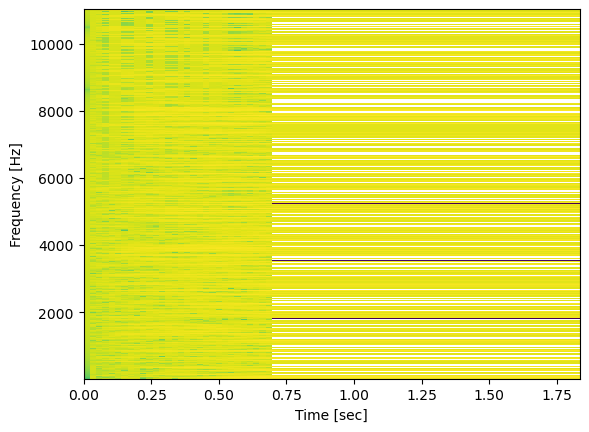

/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_7135/2736207540.py:92: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t1, f1, np.log(np.abs(TF_seperate[0])))
/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_7135/2736207540.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t1, f1, np.log(np.abs(TF_seperate[0])))


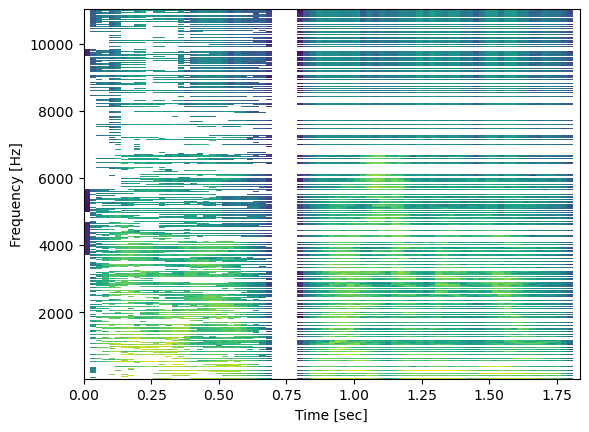

In [112]:
# duet_source_separation("dataset3", 3)

duet_source_separation_v2("dataset2", 2)

In [ ]:
# Test Cell

"""
Simply put we are solving for s within the following:

x = As

x represents an array of the audio files we are given
A represents our AoA matrix, which we will solve for with the DUET algorithm
s represents the data of the voices after being seperated, this is what we are trying to solve for
"""

# Step 1: Take STFT of both mics bin by bin 

# constants
wlen = 1024 # window length
timestep = 512 # of samples between adjacent time windows
eps = 2.2204e-16


# Reading .wav files
sample_rate0, samples0 = wavfile.read('dataset3/0.wav')
sample_rate1, samples1 = wavfile.read('dataset3/1.wav')

# Hamming Window is used for STFT
awin = np.hamming(wlen)

# Normalize
samples0=samples0/np.iinfo(samples0.dtype).max # Dividing by maximum to normalise
samples1=samples1/np.iinfo(samples1.dtype).max # Dividing by maximum to normalise

# Correct Spectrogram
f0, t0, tf0 = signal.stft(samples0, fs=sample_rate0, window=awin, nperseg=wlen)
f1, t1, tf1 = signal.stft(samples1, fs=sample_rate1, window=awin, nperseg=wlen)

# Resolution of frequency components per time point
numfreq = len(f0)

print("numfreq: ", numfreq)
# Removing DC Component to prevent divide by 0 error (when dividing by k)
f0 = f0[1:]
tf0 = tf0[1:,:]
f1 = f1[1:]
tf1 = tf1[1:,:]

# fmat calc
#calculate pos/neg frequencies for later use in delay calc ??

a=np.arange(1,((numfreq/2)+1))
b=np.arange((-(numfreq/2)+1),-1)
freq=(np.concatenate((a,b)))*((2*pi)/numfreq) #freq looks like saw signal

a=np.ones((tf0.shape[1],freq.shape[0]))
freq=np.asmatrix(freq)
a=np.asmatrix(a)
for i in range(a.shape[0]):
    a[i]=np.multiply(a[i],freq)
fmat=a.transpose()


R21 = (tf1+eps)/(tf0+eps)
#2.1HERE WE ESTIMATE THE RELATIVE ATTENUATION (alpha)
a=np.absolute(R21) #relative attenuation between the two mixtures
alpha = a - 1.0 / a #'alpha' (symmetric attenuation)
#2.2HERE WE ESTIMATE THE RELATIVE DELAY (delta)
delta_phi = -(np.imag((np.log(R21)/fmat)))
# imaginary part, 'delta' relative delay

############### OG

# Element wise division to obtain phase difference of TF data
tfmat = np.divide(tf0+eps, tf1+eps)

# Take log to obtain -jk(phi1-phi2)
tfmat_log  = np.log(tfmat)

# Take imaginary part to obtain -k(phi1-phi2)
tfmat_imag = -np.imag(tfmat_log)

delta_phi = np.zeros(tfmat_imag.shape)

print(delta_phi.shape)

# Divide by k (our fourier frequency indicies) to obtain (phi1-phi2)
for i in range(1,tfmat_imag.shape[0]):
    delta_phi[i,:] = np.divide(tfmat_imag[i,:], i)

################# OG

# # fmat
# a=np.arange(1,((numfreq/2)+1))
# b=np.arange((-(numfreq/2)+1),0)
# freq=(np.concatenate((a,b)))*((2*pi)/numfreq) #freq looks like saw signal

# a=np.ones((tf0.shape[1],freq.shape[0]))
# freq=np.asmatrix(freq)
# a=np.asmatrix(a)
# for i in range(a.shape[0]):
#     a[i]=np.multiply(a[i],freq)
# fmat=a.transpose()

# # new delta
# R21 = (tf2+eps)/(tf1+eps)
# #2.1HERE WE ESTIMATE THE RELATIVE ATTENUATION (alpha)
# a=np.absolute(R21) #relative attenuation between the two mixtures
# alpha=a-1./a #'alpha' (symmetric attenuation)
# #2.2HERE WE ESTIMATE THE RELATIVE DELAY (delta)
# delta = -(np.imag((np.log(R21)/fmat)))
# # imaginary part, 'delta' relative delay

# # kmeans = KMeans(n_clusters=3)
# # kmeans.fit(delta_phi)

# # plt.scatter(t1, f1, c=kmeans.labels_)
# # plt.show()



#Plotting a basic histogram
deltaPhi_flat = delta_phi.flatten()

TDoA = scipy.cluster.vq.kmeans(deltaPhi_flat, 3)[0]

kmeans = KMeans(n_clusters=3)
kmeans.fit(np.asarray(delta_phi))

print("labels: ", kmeans.labels_)

print("TDoA: ", TDoA)

print("del phi flattened shape: ", deltaPhi_flat.shape)
# tf_bins = len(t0) * len(f0)
# plt.hist(deltaPhi_flat, bins=tf_bins, color='skyblue', edgecolor='black')
 
# # Adding labels and title
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Basic Histogram')
 
# # Display the plot
# plt.show()

# plt.pcolormesh(t1, f1, np.log(np.abs(tfmat)))
# plt.pcolormesh(t1, f1, np.log(np.abs(tf0)))
plt.pcolormesh(t1, f1, np.log(np.abs(delta_phi)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()





# deltaPhi = spectrogram / spectrogram1

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# ax.plot_surface(frequencies[:, None], times[None, :], 10.0*np.log10(deltaPhi))
# plt.show()


# plt.pcolormesh(times, frequencies, deltaPhi)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

# plt.pcolormesh(times1, frequencies1, np.log(deltaPhi))
# #plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

# Plotting Histogram of deltaPhi
# print(deltaPhi.shape)

# deltaPhi_flat = deltaPhi.flatten()

# print(np.std(deltaPhi_flat))

# print(deltaPhi_flat[:20])

# #Plotting a basic histogram
# tf_bins = len(times) * len(frequencies)
# plt.hist(deltaPhi_flat, bins=tf_bins, color='skyblue', edgecolor='black')
 
# # Adding labels and title
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Basic Histogram')
 
# # Display the plot
# plt.show()

---
## Running and Testing
Use the cell below to run and test your code, and to get an estimate of your grade.

In [ ]:
def calculate_score(calculated, expected):
    student_result = set()
    calculated = np.array(calculated)
    if calculated.shape[0] != len(expected):
      return 0, {'Incorrect number of sources!'}
    for i in range(calculated.shape[0]):
        scipy.io.wavfile.write("temp.wav",22050,calculated[i,:])
        r = sr.Recognizer()
        with sr.AudioFile("temp.wav") as source:
            audio = r.record(source)
        try:
            text = r.recognize_sphinx(audio)
            student_result.add(text.lower())
        except:
            student_result.add("Sphinx could not understand audio")
    score = len(student_result.intersection(expected))/len(expected)
    return score, student_result
     
if __name__ == '__main__':
    groundtruth = [{"hello how are you"}, {"nice to meet you","how are you"}, {"how are you","good morning","nice to meet you"}]
    
    output = [['Dataset', 'Expected Output', 'Your Output', 'Grade', 'Points Awarded']]
    for i in range(1,4):
        directory_name = 'dataset{}'.format(i)
        student_output = duet_source_separation(directory_name, i)
        result = calculate_score(student_output, groundtruth[i-1])   
        output.append([
            str(i),
            str(groundtruth[i-1]), 
            str(result[1]), 
            "{:2.2f}%".format(result[0] * 100),
            "{:1.2f} / 5.0".format(result[0] * 5),
        ])

    output.append([
        '<i>👻 Hidden test 1 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    output.append([
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        "<i>...</i>"])
    output.append([
        '<i>👻 Hidden test 7 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    display_table(output)

---
## Rubric
You will be graded on the three data points provided to you (5 points each) and seven additional data points under different settings(10 points each). We will use the same code from the **Running and Testing** section above to grade all 10 traces of data. We will run ASR on your output to see if it generates the corrected separated speech signal. Output order does not matter. Percentage of grade for each data point is based on how many sources you estimated correctly (i.e., assume there are n sources, then you will get $\frac{1}{n} * 100\%$ for each correctedly estimated source).

---
## Submission Guidlines
This Jupyter notebook (`MP2.ipynb`) is the only file you need to submit on Gradescope. As mentioned earlier, you will only be graded using your implementation of the `duet_source_separation` function, which should only return the calculated **NOT** output any plots or data. 

**Make sure any code you added to this notebook, except for import statements, is either in a function or guarded by `__main__`(which won't be run by the autograder). Gradescope will give you immediate feedback using the provided test cases. It is your responsibility to check the output before the deadline to ensure your submission runs with the autograder.**